In [2]:
import pandas as pd
pd.options.display.max_rows = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [3]:
#Mi trabajo de tesis está basado en grabar personas caminando y analizar su caminata modelándola como un péndulo invertido, para estudiar la propiocepción de las personas
#Registro una caminata de 4 metros hasta una pared, donde la persona apoya la mano en ella al tenerla a su alcance. Luego se repite la experiencia sin el recurso visual (ojos cerrados)
#Los datos que utilizo son un df donde tengo el número de sujeto, el tramo (1=ojos abiertos, 2=ojos cerrados), la posición de los pies al tener contacto con el piso, y el momento en el que lo hacen.
#Inicialmente se buscaba comparar las caminatas entre deportistas y no deportistas, pero no se encontraron diferencias claras. Esperamos que con más cantidad de datos se pueda visualizar mejor alguna diferencia entre los grupos.

Funciones

In [4]:
#Función donde meto un dataframe con las posiciones de los pies cuando tienen contacto con el piso en los pasos, el sujeto a analizar, y el tramo (si es con los ojos abiertos o cerrados) y me calcula la distancia entre los puntos, lo cual me da un df con la distancia de los pasos de cada sujeto, de cada tramo
def Distancias(df, suj, tr):
    distances = []
    filtered_df = df[(df['sujeto'] == suj) & (df['tramo'] == tr)]
    positions = filtered_df['x'].tolist()

    for i in range(1, len(positions)):
        dist = positions[i] - positions[i-1]
        distances.append(dist)

    distances_df = pd.DataFrame({'Sujeto': [suj] * len(distances),
                                 'Tramo': [tr] * len(distances),
                                 'Distancias': distances})
    return distances_df

In [5]:
#Función donde meto un dataframe con los tiempos donde los pies tienen contacto con el piso, el sujeto y el tramo, y armo un df con el tiempo que tarda cada paso de cada sujeto en cada tramo
def Tiempo_del_paso(df, suj, tr):
    tiempo = []
    filtered_df = df[(df['sujeto'] == suj) & (df['tramo'] == tr)]
    paso = filtered_df['t'].tolist()

    for i in range(1, len(paso)):
        tiempo_paso = paso[i] - paso[i-1]
        tiempo.append(tiempo_paso)

    tiempo_df = pd.DataFrame({'Sujeto': [suj] * len(tiempo),
                                 'Tramo': [tr] * len(tiempo),
                                 'Tiempo': tiempo})
    return tiempo_df

In [6]:
#Funcion que calcula el promedio de las distancias de los tres primeros pasos, y divide las últimas dos distancias por este valor. Genera un df con esos cocientes.
def calcular_cociente(df, suj, tr):
    df_suj_tr = df[(df['Sujeto'] == suj) & (df['Tramo'] == tr)]
    primeras_tres = df_suj_tr['Distancias'].iloc[:3]
    promedio_primeras_tres = primeras_tres.mean()

    ultimas_dos = df_suj_tr['Distancias'].iloc[-2:]
    cociente_ultimas_dos = ultimas_dos / promedio_primeras_tres

    resultados_df = pd.DataFrame()
    for cociente in cociente_ultimas_dos:
        resultado = {
            'Sujeto': suj,
            'Tramo': tr,
            'Cociente_ultimas_dos': cociente
        }
        resultados_df = resultados_df.append(resultado, ignore_index=True)

    return resultados_df

# DataFrame final donde se guardarán los resultados
resultados_final_df = pd.DataFrame()

In [7]:
#Funcion que realiza el promedio del tiempo de los primeros tres pasos, y divide la duracion de los últimos dos por este valor. Genera un df con estos datos.
def cociente_temporal(df, suj, tr):
    df_suj_tr = df[(df['Sujeto'] == suj) & (df['Tramo'] == tr)]
    primeros_tres = df_suj_tr['Tiempo'].iloc[:3]
    promedio_primeros_tres = primeros_tres.mean()

    ultimos_dos = df_suj_tr['Tiempo'].iloc[-2:]
    cociente_ultimos_dos = ultimos_dos / promedio_primeros_tres

    resultados = []
    for cociente in cociente_ultimos_dos:
        resultado = {
            'Sujeto': suj,
            'Tramo': tr,
            'Cociente_ultimos_dos': cociente
        }
        resultados.append(resultado)

    resultados_tiempo_df = pd.DataFrame(resultados)
    return resultados_tiempo_df

In [8]:
#Función que realiza el valor medio entre los cocientes de distancia
def Valor_medio(df, suj, tr):
    df_suj_tr = df[(df['Sujeto'] == suj)]
    Valores = df_suj_tr['Cociente de distancias']
    Valormedio = Valores.mean()

    resultado = {
            'Sujeto': suj,
            'Tramo': tr,
            'Valor medio': Valormedio
        }
    Valormedio_df1 = pd.DataFrame([resultado], index=[0])
    return Valormedio_df1

In [9]:
#Función que realiza el valor medio entre los cocientes temporales
def Valor_medio_temp(df, suj, tr):
    df_suj_tr = df[(df['Sujeto'] == suj)]
    Valores = df_suj_tr['Cociente temporal']
    Valormedio = Valores.mean()

    resultado = {
            'Sujeto': suj,
            'Tramo': tr,
            'Valor medio': Valormedio
        }
    Valormedio_temp_df1 = pd.DataFrame([resultado], index=[0])
    return Valormedio_temp_df1

Código


In [23]:
#df con posiciones,y tiempo de los pasos de 11 sujetos caminando con los ojos abiertos (tramo1) y con los ojos cerrados (tramo2)
#Paso las posiciones a metros.
#df = pd.read_csv('C:\\Program Files\\sujetos_df.csv')
url= 'https://raw.githubusercontent.com/DanaGuber/MachineLearning/main/sujetos_df.csv'
df = pd.read_csv(url)
df['x']=0.006*df['x']
df.columns.str.match("Unnamed")
df.loc[:,~df.columns.str.match("Unnamed")]


,t,frame,x,y,tramo,sujeto
0,500.000000,15,0.270,141,1,1
1,1266.666667,38,0.924,155,1,1
2,1933.333333,58,1.566,141,1,1
3,2533.333333,76,2.298,153,1,1
4,3100.000000,93,3.018,142,1,1
5,3633.333333,109,3.558,154,1,1
6,12266.666667,368,0.324,158,2,1
7,13033.333333,391,0.810,144,2,1
8,13700.000000,411,1.566,158,2,1
9,14300.000000,429,2.190,149,2,1


In [24]:
#Aplico la función Distancias a cada tramo de cada sujeto. Creo un df con esos valores.
df_total_distancias = pd.DataFrame()
for i in range(1,12):
    for j in [1,2]:
        df_total_distancias = pd.concat([df_total_distancias,
                                      Distancias(df,i,j)],
                                     ignore_index = True)
df_total_distancias

,Sujeto,Tramo,Distancias
0,1,1,0.654
1,1,1,0.642
2,1,1,0.732
3,1,1,0.720
4,1,1,0.540
5,1,2,0.486
6,1,2,0.756
7,1,2,0.624
8,1,2,0.588
9,1,2,0.528


In [25]:
#Aplico la funcion Tiempo_del_paso a cada tramo de cada sujeto.
df_total_tiempo = pd.DataFrame()
for i in range(1,12):
    for j in [1,2]:
        df_total_tiempo = pd.concat([df_total_tiempo,
                                      Tiempo_del_paso(df,i,j)],
                                     ignore_index = True)
df_total_tiempo

,Sujeto,Tramo,Tiempo
0,1,1,766.666667
1,1,1,666.666667
2,1,1,600.000000
3,1,1,566.666667
4,1,1,533.333333
5,1,2,766.666667
6,1,2,666.666667
7,1,2,600.000000
8,1,2,566.666667
9,1,2,566.666667


In [26]:
df_total_distancias['Tiempo']=df_total_tiempo['Tiempo']
df_total=df_total_distancias.copy()
df_total

,Sujeto,Tramo,Distancias,Tiempo
0,1,1,0.654,766.666667
1,1,1,0.642,666.666667
2,1,1,0.732,600.000000
3,1,1,0.720,566.666667
4,1,1,0.540,533.333333
5,1,2,0.486,766.666667
6,1,2,0.756,666.666667
7,1,2,0.624,600.000000
8,1,2,0.588,566.666667
9,1,2,0.528,566.666667


In [27]:
#Aplico la funcion calcular_cociente para generar un df con las distancias de los últimos dos pasos dividido el promedio de los primeros tres
df_total_cocientes = pd.DataFrame()
for i in range(1,12):
    for j in [1,2]:
        df_total_cocientes = pd.concat([df_total_cocientes,
                                      calcular_cociente(df_total,i,j)],
                                     ignore_index = True)
df_total_cocientes

<ipython-input-6-7ca53f2e554f>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultado, ignore_index=True)
<ipython-input-6-7ca53f2e554f>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultado, ignore_index=True)
<ipython-input-6-7ca53f2e554f>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultado, ignore_index=True)
<ipython-input-6-7ca53f2e554f>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append(resultado, ignore_index=True)
<ipython-input-6-7ca53f2e554f>:17: FutureWarning: Th

,Sujeto,Tramo,Cociente_ultimas_dos
0,1.0,1.0,1.065089
1,1.0,1.0,0.798817
2,1.0,2.0,0.848875
3,1.0,2.0,0.598071
4,2.0,1.0,1.054545
5,2.0,1.0,1.036364
6,2.0,2.0,0.920000
7,2.0,2.0,0.768000
8,3.0,1.0,1.054545
9,3.0,1.0,1.036364


In [28]:
#Aplico la funcion cocicente_temporal para generar un df con los tiempos de los últimos dos pasos dividido el promedio de los primeros tres
df_total_cocientes_temporales = pd.DataFrame()
for i in range(1,12):
    for j in [1,2]:
        df_total_cocientes_temporales = pd.concat([df_total_cocientes_temporales,
                                      cociente_temporal(df_total,i,j)],
                                     ignore_index = True)
df_total_cocientes_temporales

,Sujeto,Tramo,Cociente_ultimos_dos
0,1,1,0.836066
1,1,1,0.786885
2,1,2,0.836066
3,1,2,0.836066
4,2,1,0.915254
5,2,1,0.915254
6,2,2,0.894737
7,2,2,0.947368
8,3,1,0.915254
9,3,1,0.915254


In [29]:
#df final con todo lo que me interesa
df_total=pd.concat([df_total_cocientes, df_total_cocientes_temporales['Cociente_ultimos_dos']], axis=1)

In [30]:
df_total.columns=['Sujeto', 'Tramo', 'Cociente de distancias', 'Cociente temporal']
df_total


,Sujeto,Tramo,Cociente de distancias,Cociente temporal
0,1.0,1.0,1.065089,0.836066
1,1.0,1.0,0.798817,0.786885
2,1.0,2.0,0.848875,0.836066
3,1.0,2.0,0.598071,0.836066
4,2.0,1.0,1.054545,0.915254
5,2.0,1.0,1.036364,0.915254
6,2.0,2.0,0.920000,0.894737
7,2.0,2.0,0.768000,0.947368
8,3.0,1.0,1.054545,0.915254
9,3.0,1.0,1.036364,0.915254


Gráficos

In [31]:
#separo el df_total, en dos df diferentes según el tramo
Ojosabiertos=df_total[df_total.Tramo.isin([1])]
Ojoscerrados=df_total[df_total.Tramo.isin([2])]
Ojosabiertos

,Sujeto,Tramo,Cociente de distancias,Cociente temporal
0,1.0,1.0,1.065089,0.836066
1,1.0,1.0,0.798817,0.786885
4,2.0,1.0,1.054545,0.915254
5,2.0,1.0,1.036364,0.915254
8,3.0,1.0,1.054545,0.915254
9,3.0,1.0,1.036364,0.915254
12,4.0,1.0,1.005882,0.870968
13,4.0,1.0,0.855882,0.919355
16,5.0,1.0,1.020408,0.915254
17,5.0,1.0,0.642857,0.915254


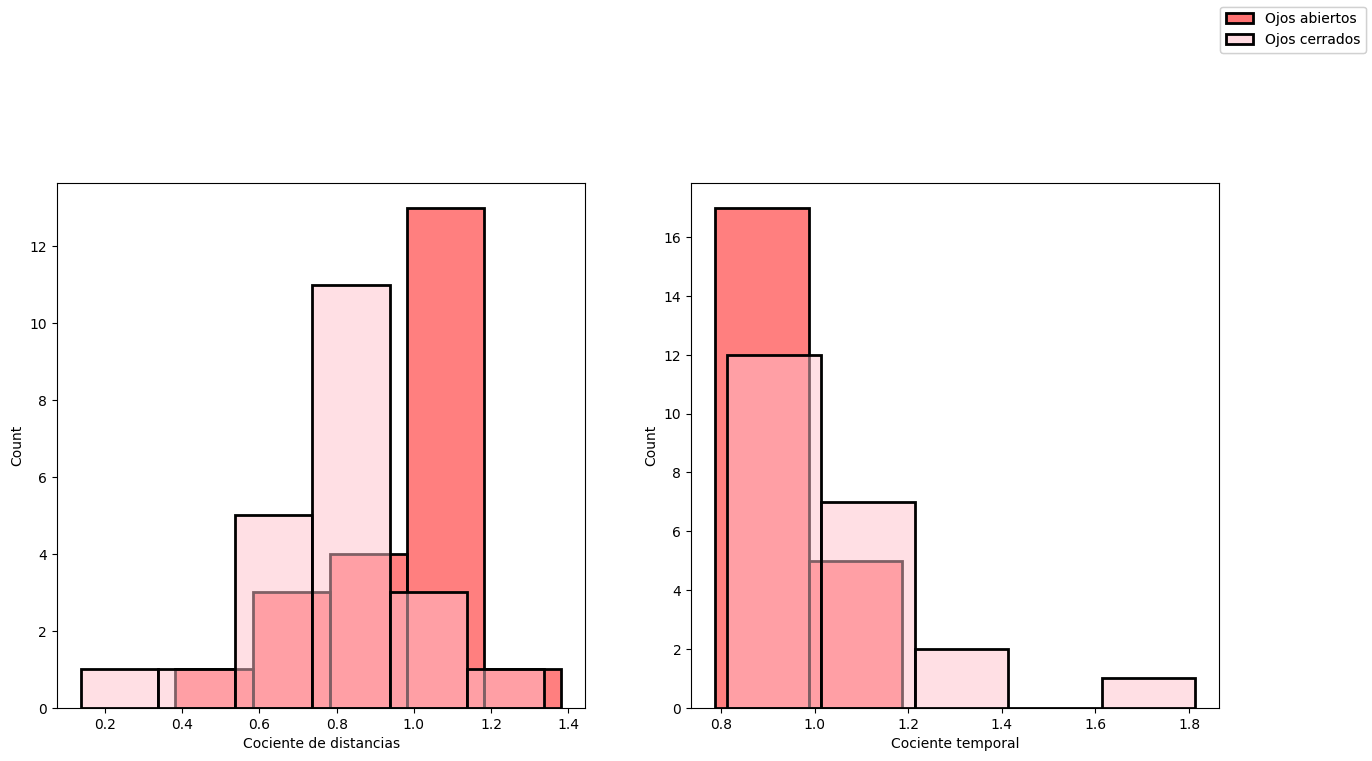

In [32]:
#Histograma de los cocientes de distancia y los temporales
#En el histograma de distancia puede observarse que el conjunto de datos con los ojos cerrados poseen valores más pequeños, mientras que en el temporal, valores más grandes.
#Esto indica que los pasos tienden a ser más cortos y más lentos por la inseguridad de no saber cuanta distancia falta para la pared.
fig = plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.histplot(Ojosabiertos['Cociente de distancias'], color = "red", alpha = 0.5,  linewidth = 2, binwidth = 0.2)
sns.histplot(Ojoscerrados['Cociente de distancias'], color = "pink", alpha = 0.5, linewidth = 2, binwidth = 0.2)
fig.legend(labels=['Ojos abiertos','Ojos cerrados'])
plt.subplot(2,2,2)
sns.histplot(Ojosabiertos['Cociente temporal'], color = "red", alpha = 0.5,  linewidth = 2, binwidth = 0.2)
sns.histplot(Ojoscerrados['Cociente temporal'], color = "pink", alpha = 0.5, linewidth = 2, binwidth = 0.2)
fig.legend(labels=['Ojos abiertos','Ojos cerrados'])

In [33]:
#Saco el valor medio de los dos valores de distancia del tramo 1, de cada sujeto.
df1_valormedio = pd.DataFrame()
for i in range(1, 12):
    df1_valormedio = pd.concat([df1_valormedio, Valor_medio(Ojosabiertos, i, 1)], ignore_index=True)

df1_valormedio

,Sujeto,Tramo,Valor medio
0,1,1,0.931953
1,2,1,1.045455
2,3,1,1.045455
3,4,1,0.930882
4,5,1,0.831633
5,6,1,0.997059
6,7,1,0.864130
7,8,1,1.018051
8,9,1,0.828000
9,10,1,1.113281


In [34]:
#Saco el valor medio de los dos valores de distancia del tramo 2, de cada sujeto.
df2_valormedio = pd.DataFrame()
for i in range(1, 12):
    df2_valormedio = pd.concat([df2_valormedio, Valor_medio(Ojoscerrados, i, 2)], ignore_index=True)

df2_valormedio

,Sujeto,Tramo,Valor medio
0,1,2,0.723473
1,2,2,0.844000
2,3,2,0.844000
3,4,2,0.595238
4,5,2,0.691935
5,6,2,1.089928
6,7,2,0.240458
7,8,2,0.949219
8,9,2,0.855882
9,10,2,0.852399


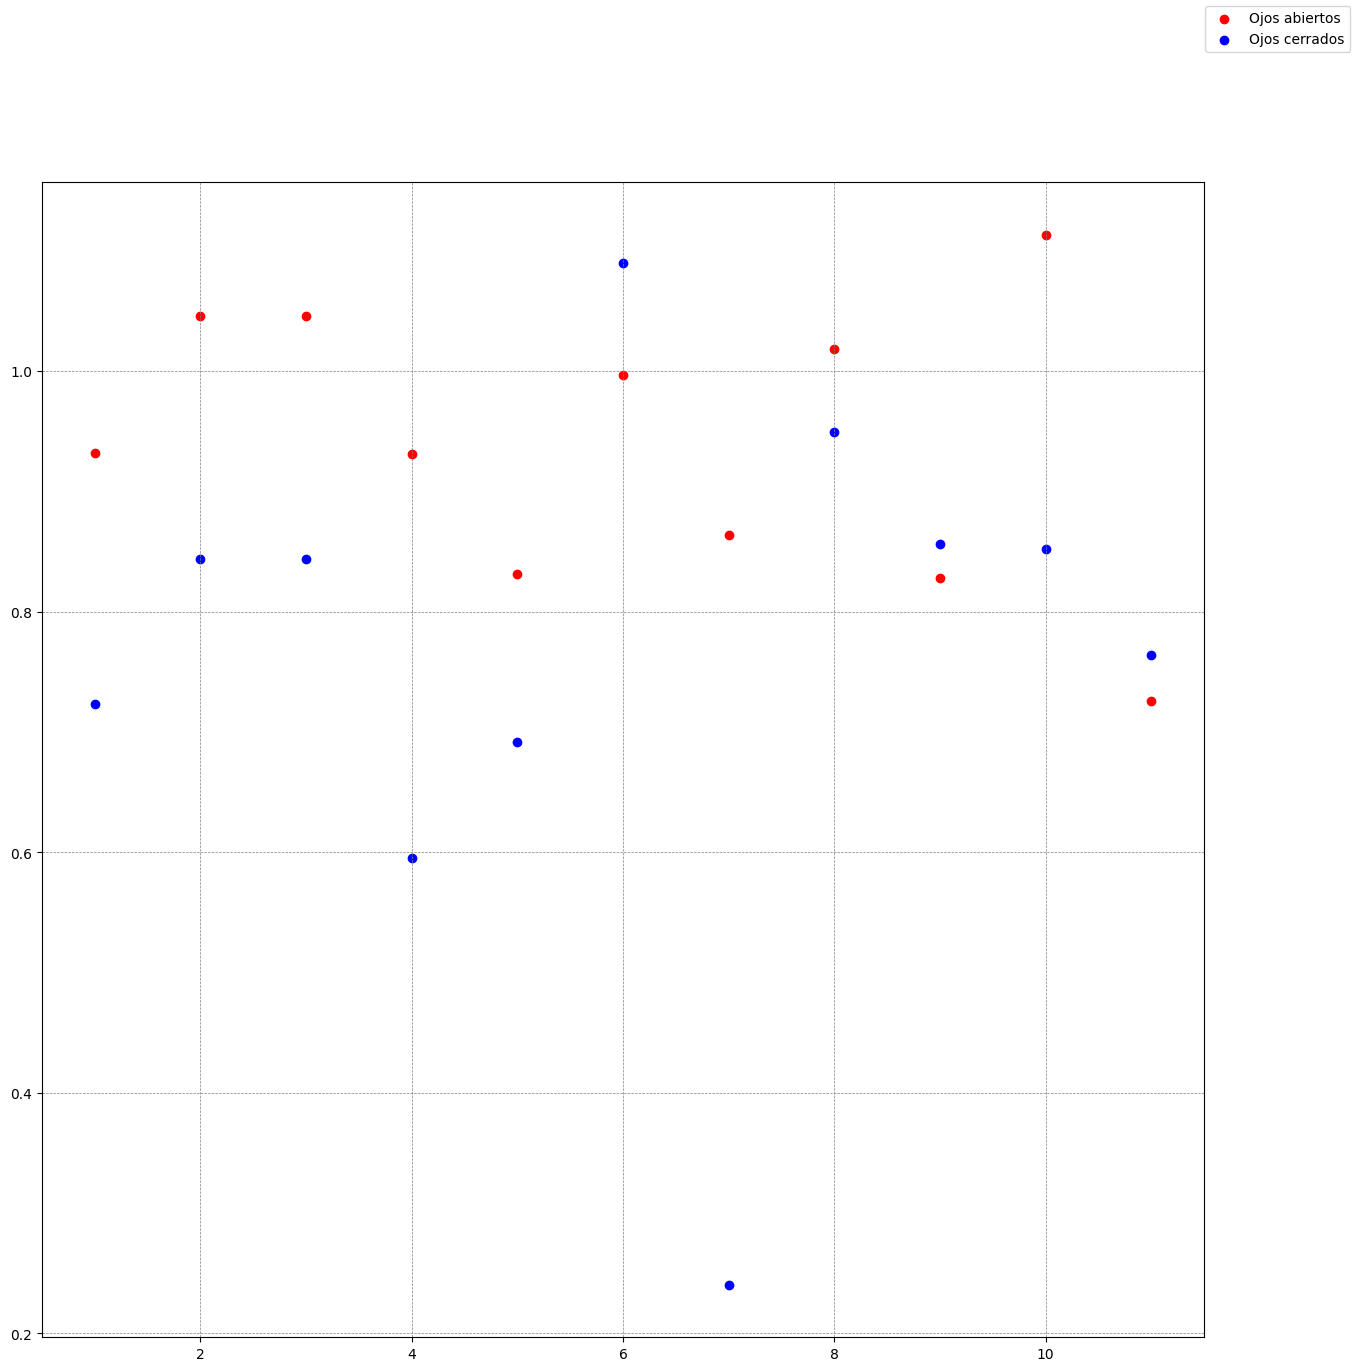

In [35]:
#grafico el valor medio de los pasos con ojos cerrados (azul) y con ojos abiertos (rojo), se observa que en la mayoría de los casos los rojos poseen un valor mayor lo cual concuerda con la idea de que los pasos al tener los ojos cerrados comienzan a ser más cortos por la inseguridad de cuanta distancia falta para llegar a la pared.
fig = plt.figure(figsize=(15,15))
plt.scatter(df1_valormedio['Sujeto'], df1_valormedio['Valor medio'], color = 'red')
plt.scatter(df2_valormedio['Sujeto'], df2_valormedio['Valor medio'], color ='blue')
plt.grid(color='gray', linestyle='dashed', linewidth=0.5, which='major')
fig.legend(labels=['Ojos abiertos','Ojos cerrados'])




In [36]:
#Saco el valor medio de los dos valores temporales del tramo 1, de cada sujeto.
df1_valormedio_temp = pd.DataFrame()
for i in range(1, 12):
    df1_valormedio_temp = pd.concat([df1_valormedio_temp, Valor_medio_temp(Ojosabiertos, i, 1)], ignore_index=True)

df1_valormedio_temp

,Sujeto,Tramo,Valor medio
0,1,1,0.811475
1,2,1,0.915254
2,3,1,0.915254
3,4,1,0.895161
4,5,1,0.915254
5,6,1,1.036364
6,7,1,0.972222
7,8,1,1.055556
8,9,1,0.900000
9,10,1,1.042373


In [37]:
#Saco el valor medio de los dos valores temporales del tramo 2, de cada sujeto.
df2_valormedio_temp = pd.DataFrame()
for i in range(1, 12):
    df2_valormedio_temp = pd.concat([df2_valormedio_temp, Valor_medio_temp(Ojoscerrados, i, 2)], ignore_index=True)

df2_valormedio_temp

,Sujeto,Tramo,Valor medio
0,1,2,0.836066
1,2,2,0.921053
2,3,2,0.921053
3,4,2,1.195312
4,5,2,0.959016
5,6,2,0.991525
6,7,2,1.343750
7,8,2,0.960000
8,9,2,1.148936
9,10,2,1.125000


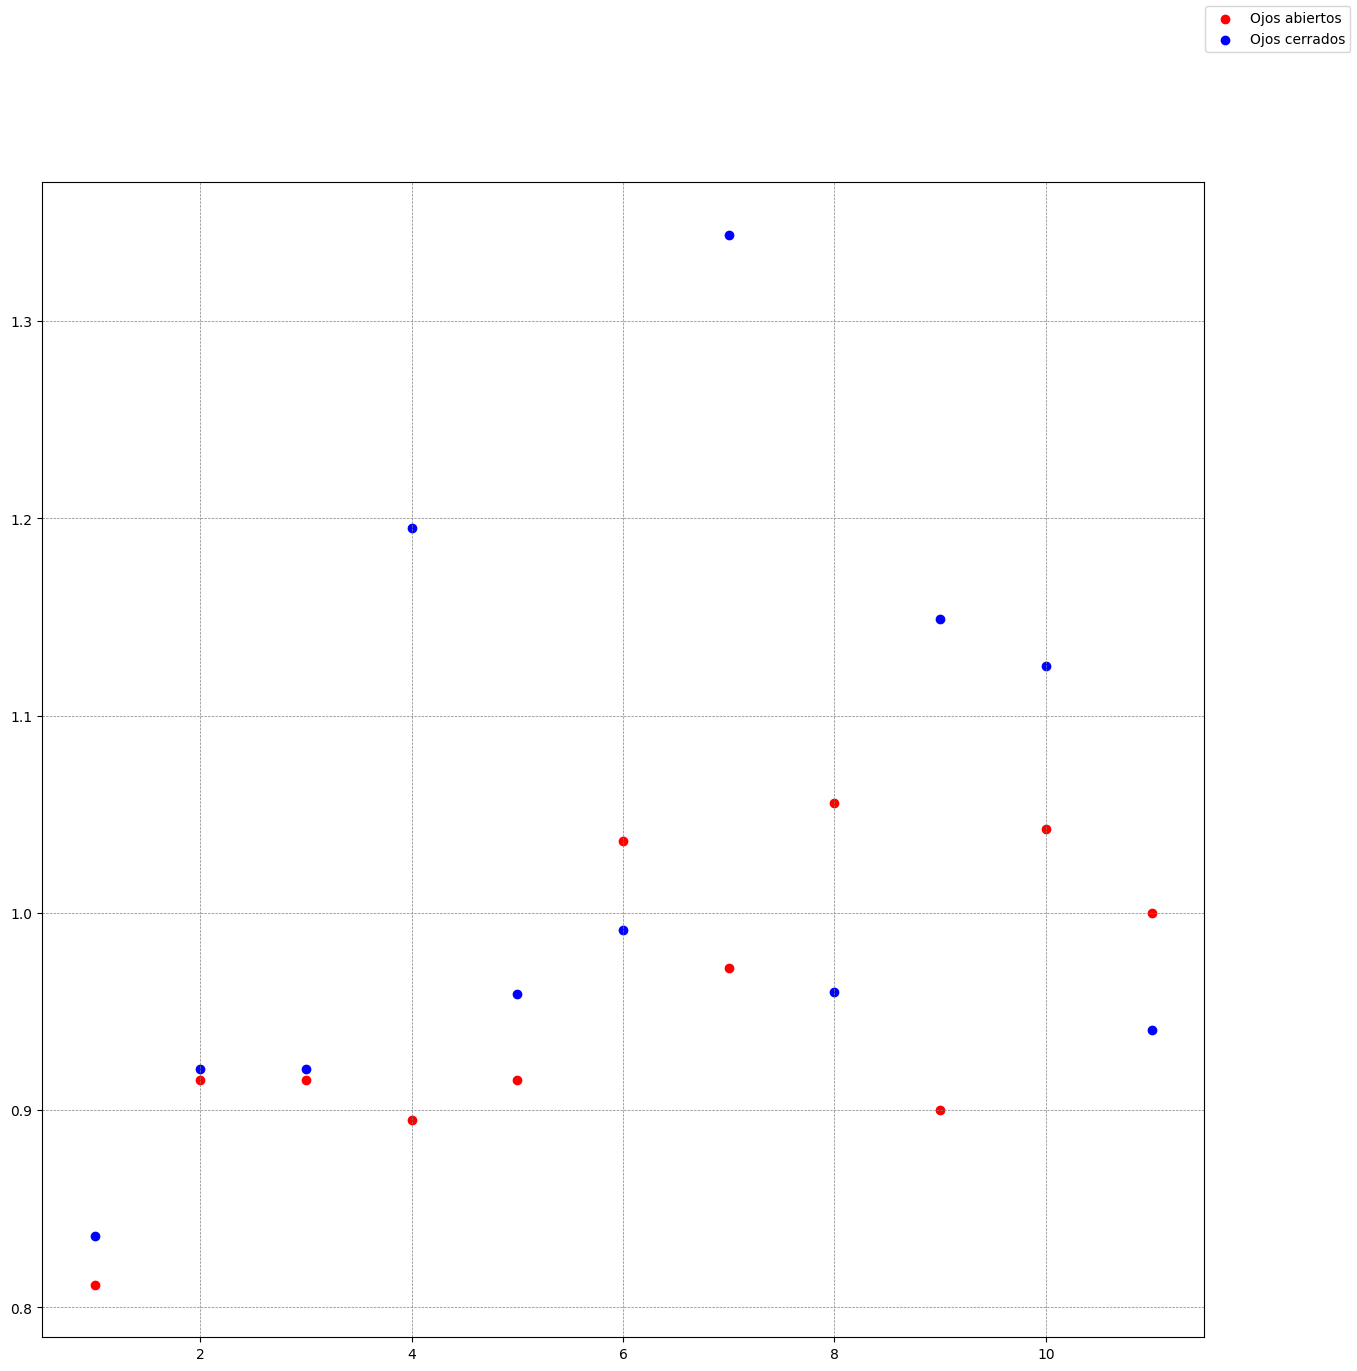

In [38]:
#grafico el valor medio de los pasos con ojos cerrados (azul) y con ojos abiertos (rojo), se observa que en la mayoría de los casos los rojos poseen un valor menor lo cual concuerda con la idea de que los pasos al tener los ojos cerrados comienzan a ser más lentos por la inseguridad de cuanta distancia falta para llegar a la pared.
fig = plt.figure(figsize=(15,15))
plt.scatter(df1_valormedio_temp['Sujeto'], df1_valormedio_temp['Valor medio'], color = 'red')
plt.scatter(df2_valormedio_temp['Sujeto'], df2_valormedio_temp['Valor medio'], color ='blue')
plt.grid(color='gray', linestyle='dashed', linewidth=0.5, which='major')
fig.legend(labels=['Ojos abiertos','Ojos cerrados'])



Machine Learning

Arbol de decisión

In [39]:
#La idea es usar clasificadores con la intención de, teniendo valores de distancia y tiempo, poder identificar si la caminata es con los ojos abiertos o con los ojos cerrados.
Y=df_total[['Tramo']]
X=df_total[['Cociente de distancias','Cociente temporal']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [47]:
#las métricas van del 0 al 1, siendo 1 su mejor valor, por lo que en este caso los valores dan bastante bien
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, Y_train)
clf2.score(X,Y), accuracy_score(Y, clf2.predict(X)), precision_score(Y, clf2.predict(X),average='weighted'),f1_score(Y, clf2.predict(X),average='weighted')
Y_pred=clf2.predict(X_test)

[Text(0.5333333333333333, 0.9285714285714286, 'x[0] <= 0.945\ngini = 0.496\nsamples = 35\nvalue = [19, 16]'),
 Text(0.3333333333333333, 0.7857142857142857, 'x[1] <= 1.031\ngini = 0.432\nsamples = 19\nvalue = [6, 13]'),
 Text(0.26666666666666666, 0.6428571428571429, 'x[0] <= 0.705\ngini = 0.497\nsamples = 13\nvalue = [6, 7]'),
 Text(0.13333333333333333, 0.5, 'x[1] <= 0.854\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.06666666666666667, 0.35714285714285715, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.2, 0.35714285714285715, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.4, 0.5, 'x[1] <= 0.8\ngini = 0.375\nsamples = 8\nvalue = [2, 6]'),
 Text(0.3333333333333333, 0.35714285714285715, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4666666666666667, 0.35714285714285715, 'x[0] <= 0.852\ngini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(0.4, 0.21428571428571427, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.5333333333333333, 0.21428571428571427, 'x[1] <= 0.907\

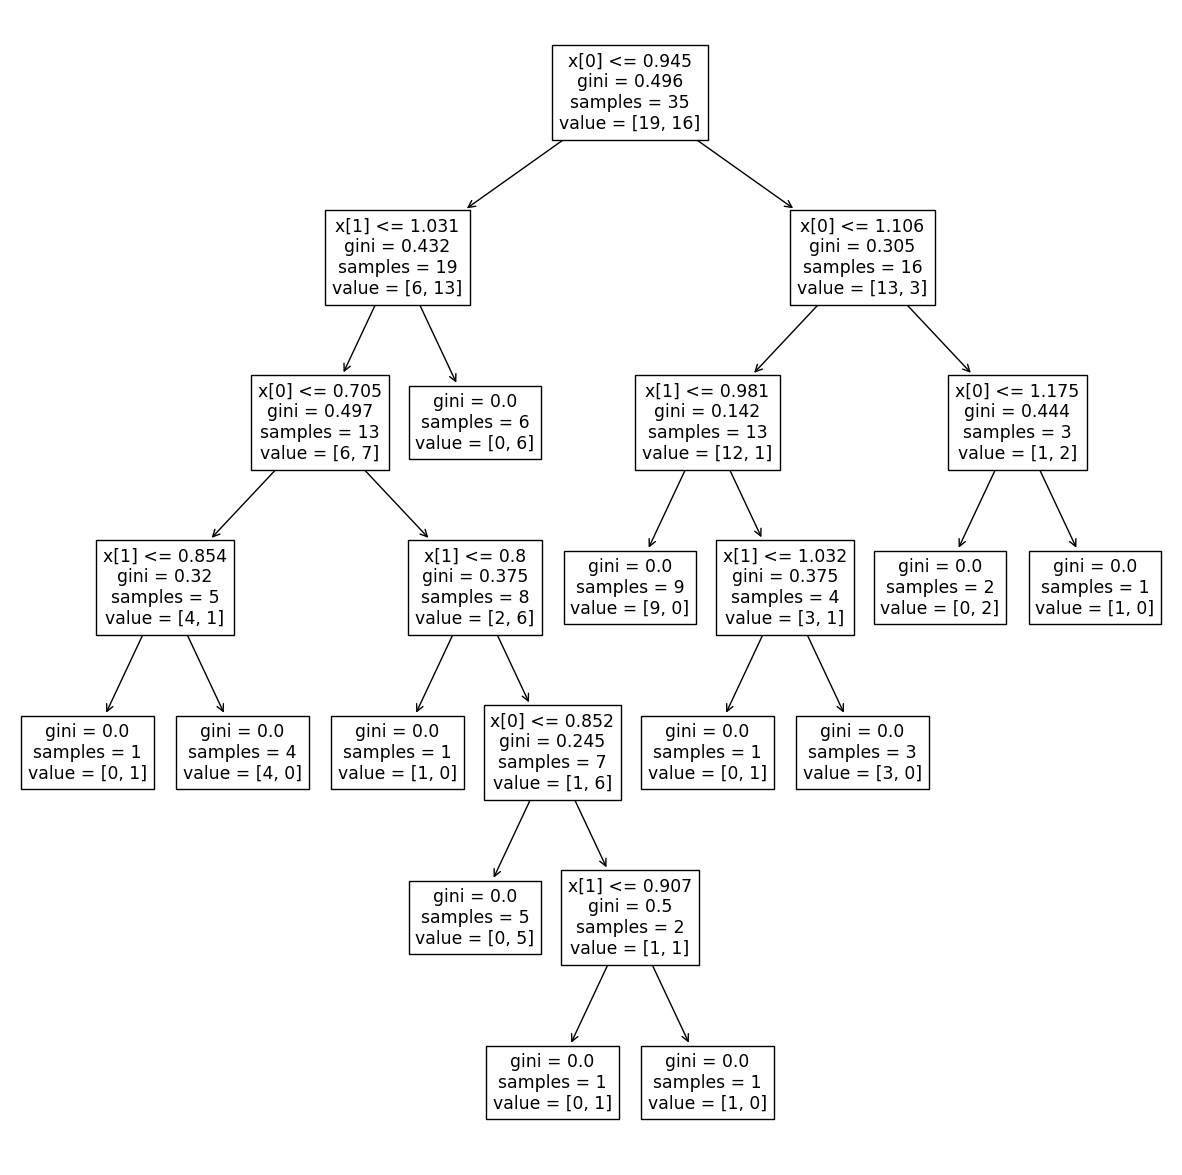

In [48]:
from sklearn import tree
fig = plt.figure(figsize=(15,15))
tree.plot_tree(clf2)

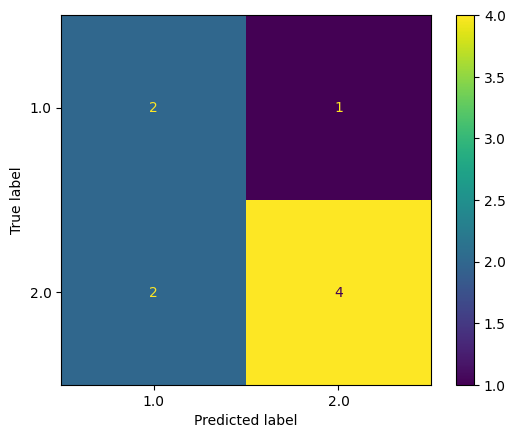

In [51]:
#La matriz no da muy bien, pero seguro mejoraría aumentando la cantidad de datos.
#disp = metrics.plot_confusion_matrix(clf2, X_test, Y_test)
#disp.figure_.suptitle("Confusion Matrix");
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred, labels=clf2.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot()


Random Forest

In [54]:
#Las métricas en este caso también dan valores encima de 0.9
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, Y_train)

pred_rf_test=rf.predict(X_test)
proba_pred_test=rf.predict_proba(X_test)
print('predicciones RF: ', pred_rf_test)
print('verdaderos:', Y_test.values)

print(f"RF Accuracy: {rf.score(X_test, Y_test)}")
clf2.score(X,Y), accuracy_score(Y, clf2.predict(X)), precision_score(Y, clf2.predict(X),average='weighted'),f1_score(Y, clf2.predict(X),average='weighted')
Y_pred=rf.predict(X_test)

predicciones RF:  [1. 2. 1. 1. 2. 2. 2. 1. 1.]
verdaderos: [[1.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]]
RF Accuracy: 0.7777777777777778


<ipython-input-54-69a129b718b1>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, Y_train)


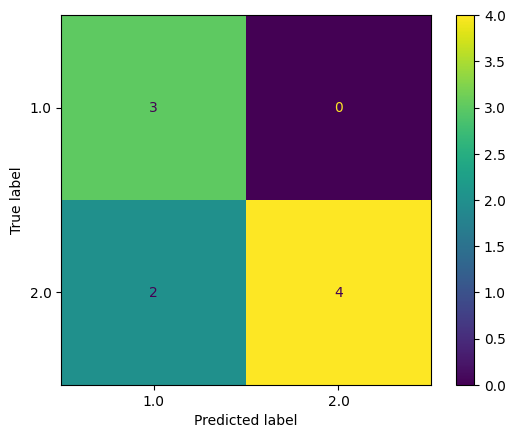

In [55]:
#La matriz de confusión en este caso también debería tener valores más altos en la diagonal principal. Probablemente debido a la baja cantidad de datos,
cm = confusion_matrix(Y_test, Y_pred, labels=clf2.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf2.classes_)
disp.plot()